# Import Libraries

In [1]:
%%capture
!pip install pyDOE

In [2]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cpu


# *Data Prep*

Training and Testing data is prepared from the solution file

In [3]:
# Specify the number of grid points
num_grid_pts = 256

x_1 = np.linspace(-1,1,num_grid_pts)  # num_grid_pts between -1 and 1 [num_grid_pts x 1]
x_2 = np.linspace(1,-1,num_grid_pts)  # num_grid_pts points between 1 and -1 [num_grid_pts x 1]

X, Y = np.meshgrid(x_1,x_2)

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [4]:
# Test data for the boundary conditions
# Flatten the X and Y grids column-wise ('F' order for Fortran-like indexing) and combine them into a 2D array
X_u_test = np.hstack((X.flatten(order='F')[:, None], Y.flatten(order='F')[:, None]))

# Domain bounds
lb = np.array([-1, -1])  # Lower bound for the domain in both dimensions (x and y)
ub = np.array([1, 1])    # Upper bound for the domain in both dimensions (x and y)

# Constants for the wave equation or PDE parameters
a_1 = 1  # Coefficient for the sine term in the x-dimension
a_2 = 1  # Coefficient for the sine term in the y-dimension
k = 2*np.pi    # Constant parameter, often related to wave number

# Analytical solution of the PDE (sinusoidal) chosen for convenience
# sin(a_1 * x) * sin(a_2 * y) generates a 2D sine wave solution
usol = np.sin(a_1 * X) * np.sin(a_2 * Y)

# Flatten the solution array in column-major order ('F') and reshape it into a column vector
u_true = usol.flatten('F')[:, None]

# Training Data

In [5]:
def trainingdata(N_u, N_f):
    """
    Generates training data for boundary conditions and collocation points.

    This function assembles the training data from the boundary edges of a solution grid
    and generates random collocation points using Latin Hypercube Sampling (LHS).
    It selects a specified number of training points from the boundary conditions
    and creates collocation points for training a PDE-based model.

    Parameters
    ----------
    N_u : int
        The number of boundary condition points to select for training.
    N_f : int
        The number of collocation points to generate using Latin Hypercube Sampling.

    Returns
    -------
    X_f_train : numpy.ndarray
        Array containing the collocation points (and boundary points).
    X_u_train : numpy.ndarray
        Array containing the selected boundary points.
    u_train : numpy.ndarray
        Array containing the corresponding boundary condition values.

    Notes
    -----
    - The function uses random sampling from the boundary data, so each run may return
      different training points.
    - The collocation points are generated in a 2D space using Latin Hypercube Sampling.
    """

    # Extract left edge boundary points for x and corresponding u values
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = usol[:, 0][:, None]

    # Extract right edge boundary points for x and corresponding u values
    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = usol[:, -1][:, None]

    # Extract top edge boundary points for x and corresponding u values
    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = usol[0, :][:, None]

    # Extract bottom edge boundary points for x and corresponding u values
    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = usol[-1, :][:, None]

    # Combine all edge points into one array
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points for training from the boundary data
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    """ Collocation Points """

    # Latin Hypercube Sampling for generating N_f collocation points
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Append training points to the collocation points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Physics Informed Neural Network

In [6]:
class SequentialModel(nn.Module):
    """
    A custom sequential neural network model for solving boundary condition (BC) and
    partial differential equation (PDE) loss functions using PyTorch.

    Parameters
    ----------
    layers : list
        A list defining the number of nodes in each layer of the network.
    """

    def __init__(self, layers):
        """
        Initializes the SequentialModel with the specified layers, activation function,
        loss function, and weight initialization.

        Parameters
        ----------
        layers : list
            A list of integers where each element defines the number of neurons
            in the respective layer.
        """
        super().__init__()  # Call the parent class (nn.Module) initializer

        # LeakyReLU activation function
        self.activation = nn.LeakyReLU()

        # Mean squared error (MSE) loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # Initialize the network as a list of linear layers
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        # Xavier normal initialization for weights and setting biases to zero
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        """
        Forward pass through the network. Scales the input features and passes them through
        the layers of the model, applying the activation function after each layer.

        Parameters
        ----------
        x : torch.Tensor or numpy array
            Input tensor or array to be processed.

        Returns
        -------
        torch.Tensor
            Output of the model.
        """
        # Convert numpy array to tensor if needed
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        # Convert lower and upper bounds to tensors
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # Feature scaling
        x = (x - l_b) / (u_b - l_b)

        # Convert input to float
        a = x.float()

        # Pass through each linear layer with activation
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)

        # Final layer without activation
        a = self.linears[-1](a)

        return a

    def loss_BC(self, x, y):
        """
        Computes the boundary condition (BC) loss using MSE between the model's predictions
        and ground truth.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        y : torch.Tensor
            Ground truth tensor.

        Returns
        -------
        torch.Tensor
            Loss value for the boundary condition.
        """
        return self.loss_function(self.forward(x), y)

    def loss_PDE(self, x_to_train_f):
        """
        Computes the partial differential equation (PDE) loss using automatic differentiation
        to calculate the second-order derivatives.

        Parameters
        ----------
        x_to_train_f : torch.Tensor
            Input tensor for training PDE.

        Returns
        -------
        torch.Tensor
            Loss value for the PDE.
        """
        x_1_f = x_to_train_f[:, [0]]
        x_2_f = x_to_train_f[:, [1]]

        g = x_to_train_f.clone()
        g.requires_grad = True

        # Forward pass through the network
        u = self.forward(g)

        # Compute first-order derivatives
        u_x = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(device),
                            retain_graph=True, create_graph=True)[0]

        # Compute second-order derivatives
        u_xx = autograd.grad(u_x, g, torch.ones(x_to_train_f.shape).to(device),
                             create_graph=True)[0]
        u_xx_1 = u_xx[:, [0]]
        u_xx_2 = u_xx[:, [1]]

        # Define the PDE residual
        q = k**2 * torch.sin(a_1 * x_1_f) * torch.sin(a_2 * x_2_f)
        f = u_xx_1 + u_xx_2 + k ** 2 * u - q

        # PDE loss
        return self.loss_function(f, f_hat)

    def loss(self, x, y, x_to_train_f):
        """
        Computes the total loss by combining boundary condition (BC) loss and
        partial differential equation (PDE) loss.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor for BC.
        y : torch.Tensor
            Ground truth tensor for BC.
        x_to_train_f : torch.Tensor
            Input tensor for PDE.

        Returns
        -------
        torch.Tensor
            Total loss value.
        """
        loss_u = self.loss_BC(x, y)
        loss_f = self.loss_PDE(x_to_train_f)

        return loss_u + loss_f

    def closure(self):
        """
        Defines the closure function for the optimizer to minimize the loss. This function is
        used during the optimization process.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        adam_optimizer.zero_grad()

        # Compute total loss
        loss_val = self.loss(X_u_train, u_train, X_f_train)

        # Test the model and get error metrics
        error_vec, _ = self.test()

        print(loss, error_vec)

        # Backpropagation
        loss_val.backward()

        return loss_val

    def test(self):
        """
        Tests the model on the test data and computes the relative L2 norm of the error.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted output reshaped as a 2D array.
        """
        # Model prediction on test data
        u_pred = self.forward(X_u_test_tensor)

        # Compute relative L2 norm of the error
        error_vec = torch.linalg.norm((u - u_pred), 2) / torch.linalg.norm(u, 2)

        # Reshape the predicted output to a 2D array
        u_pred = np.reshape(u_pred.cpu().detach().numpy(), (num_grid_pts, num_grid_pts), order='F')

        return error_vec, u_pred

# *Solution Plot*

In [7]:
def solutionplot(u_pred, X_u_train, u_train):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.

    Parameters
    ----------
    u_pred : numpy.ndarray
        Predicted solution values from the model.
    X_u_train : numpy.ndarray
        Training points used for boundary conditions (not plotted but included for context).
    u_train : numpy.ndarray
        Corresponding boundary condition values (not plotted but included for context).
    """

    # Ground truth solution plot
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')  # Plot the ground truth solution 'usol' using a color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Predicted solution plot
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')  # Plot the predicted solution 'u_pred' using the same color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Absolute error plot
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')  # Plot the absolute error between ground truth and prediction
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    plt.tight_layout()  # Adjust subplots to fit into the figure area cleanly

    # Save the figure as a high-resolution image file
    plt.savefig('Helmholtz_non_stiff.png', dpi=500, bbox_inches='tight')

# LBFGS Closure

In [8]:
def LBFGS_closure():
    """
    Computes the loss and its gradients for use with the LBFGS optimizer.

    This closure function is necessary for optimizers like LBFGS which require
    multiple evaluations of the function. It performs the following:
    - Resets gradients to zero.
    - Calculates the loss using the physics-informed neural network (PINN) model.
    - Backpropagates the gradients of the loss.

    Returns
    -------
    loss : torch.Tensor
        The computed loss value.
    """
    # Zero out the gradients of the optimizer before backpropagation
    lbfgs_optimizer.zero_grad()

    # Compute the loss using the physics-informed neural network (PINN)
    loss = PINN.loss(X_u_train, u_train, X_f_train)

    # Perform backpropagation to compute the gradients of the loss
    loss.backward()

    # Return the loss value to the optimizer
    return loss

# Main

SequentialModel(
  (activation): LeakyReLU(negative_slope=0.01)
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1-3): 3 x Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)
Adam - Iteration 0: Loss 127.4635238647461, Error 1.0881916284561157
Adam - Iteration 100: Loss 0.013419751077890396, Error 0.010359524749219418
Adam - Iteration 200: Loss 0.06785963475704193, Error 0.016321057453751564
Adam - Iteration 300: Loss 0.0032789004035294056, Error 0.00509826373308897
Adam - Iteration 400: Loss 0.002172403270378709, Error 0.0046583483926951885
Adam - Iteration 500: Loss 0.0034763498697429895, Error 0.006231103092432022
Adam - Iteration 600: Loss 0.0014485311694443226, Error 0.0034476863220334053
Adam - Iteration 700: Loss 0.0009760681423358619, Error 0.0028766286559402943
Adam - Iteration 800: Loss 0.0015581096522510052, Error 0.003478811588138342
Adam 

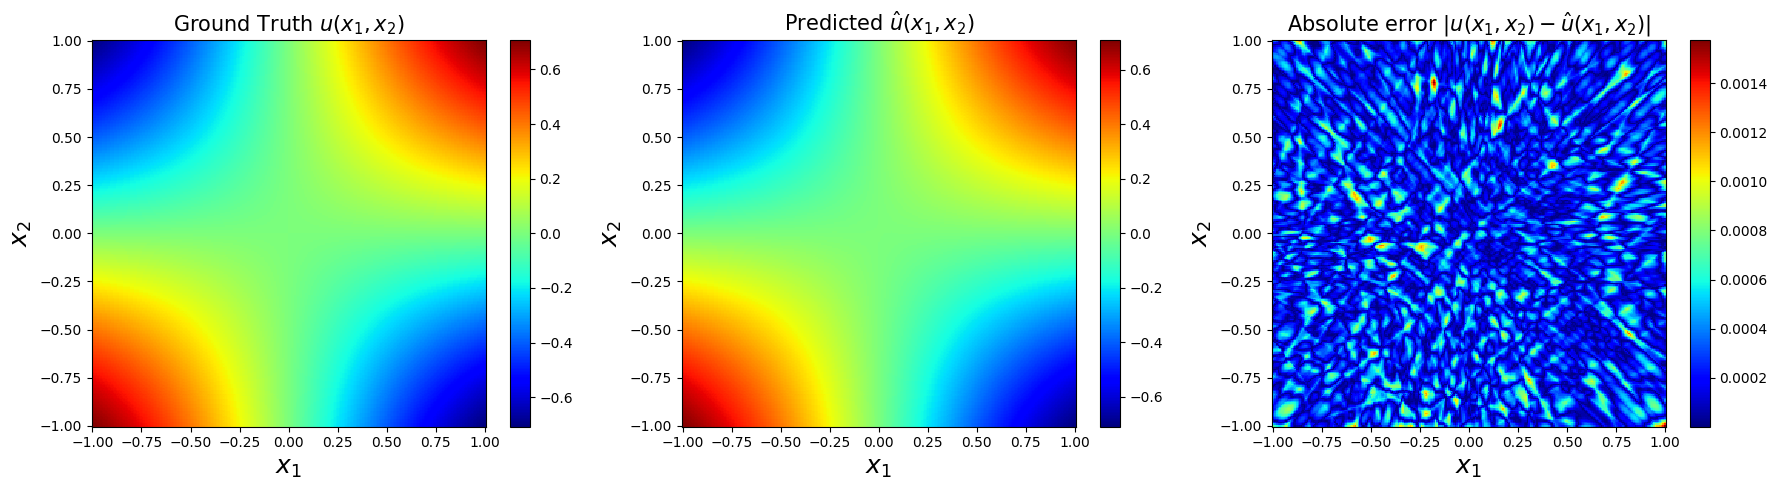

In [9]:
# Number of training points and collocation points
N_u = 500  # Total number of data points for 'u', used to train the model on boundary conditions
N_f = 10000  # Total number of collocation points for training the physics-informed part of the model

# Generate training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u, N_f)

# Convert the numpy arrays to PyTorch tensors and move them to the GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Neural network architecture definition

# Input layer with 2 nodes, 4 hidden layers with 200 nodes, and an output layer with 1 node
layers = np.array([2, 200, 200, 200, 200, 1])

# Initialize the neural network model
PINN = SequentialModel(layers)

# Move the model to the GPU (if available)
PINN.to(device)

# Print a summary of the neural network architecture
print(PINN)

# Store the parameters of the neural network for optimization
params = list(PINN.parameters())

# Optimization Section

# Adam Optimizer
adam_optimizer = optim.Adam(PINN.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08,
                          weight_decay=1e-4, amsgrad=False)

# L-BFGS Optimizer (for fine-tuning)
lbfgs_optimizer = optim.LBFGS(PINN.parameters(), max_iter=500, tolerance_grad=1e-5, tolerance_change=1e-9,
                              history_size=100)

start_time = time.time()  # Start the timer to measure training time

# Number of iterations for Adam optimizer
adam_iter = 1000

# Adam training loop
for i in range(adam_iter):
    # Calculate the total loss (boundary condition loss + physics-informed loss)
    loss = PINN.loss(X_u_train, u_train, X_f_train)

    # Zero the gradient buffers of all parameters
    adam_optimizer.zero_grad()

    # Backpropagation to calculate gradients
    loss.backward()

    # Update the model parameters using the optimizer
    adam_optimizer.step()

    # Print loss and error every 100 iterations
    if i % (adam_iter // 10) == 0:
        error_vec, _ = PINN.test()  # Evaluate the model on test data
        print(f"Adam - Iteration {i}: Loss {loss.item()}, Error {error_vec.item()}")

# L-BFGS fine-tuning and optimizer
lbfgs_optimizer.step(LBFGS_closure)

# After L-BFGS optimization
error_vec, u_pred = PINN.test()
print(f'L-BFGS Test Error: {error_vec.item()}')

# Measure the elapsed training time
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

# Evaluate the model accuracy on test data
error_vec, u_pred = PINN.test()
print('Test Error: %.5f' % (error_vec))

# Plot the ground truth, predicted solution, and error
solutionplot(u_pred, X_u_train, u_train)